# 05 - Classificando patologias em toras usando combinação de `OTSU_treshold + LBP + SVM` e normalizando amostras pela dimensão da imagem (quantidade de píxels)

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)

    img_ostu = img >= threshold_otsu(img)
    
    lbp = local_binary_pattern(image=img_ostu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pela quantidade de píxeis
    arr /= np.product(img.shape)

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_norm1_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.004063,0.004706,0.0,0.004355,0.0,0.005065,0.0,0.004281,0.0,0.0,...,0.0,0.003543,0.0,0.003511,0.0,0.003532,0.0,0.866764,0.031688,0
1,0.003519,0.004500,0.0,0.004050,0.0,0.004563,0.0,0.003742,0.0,0.0,...,0.0,0.008814,0.0,0.007903,0.0,0.007989,0.0,0.776488,0.048305,0
2,0.003567,0.004862,0.0,0.003211,0.0,0.004885,0.0,0.003059,0.0,0.0,...,0.0,0.005401,0.0,0.005750,0.0,0.005122,0.0,0.835412,0.036268,0
3,0.002983,0.005199,0.0,0.004436,0.0,0.005238,0.0,0.004172,0.0,0.0,...,0.0,0.009336,0.0,0.009732,0.0,0.009251,0.0,0.745978,0.052054,0
4,0.003227,0.005966,0.0,0.005349,0.0,0.005908,0.0,0.005173,0.0,0.0,...,0.0,0.009814,0.0,0.010398,0.0,0.010054,0.0,0.705719,0.064854,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.002471,0.004380,0.0,0.003594,0.0,0.004661,0.0,0.002752,0.0,0.0,...,0.0,0.011849,0.0,0.012073,0.0,0.010389,0.0,0.739611,0.029593,3
356,0.000784,0.001330,0.0,0.001440,0.0,0.001476,0.0,0.001695,0.0,0.0,...,0.0,0.011263,0.0,0.013286,0.0,0.011391,0.0,0.795436,0.018171,3
357,0.000851,0.001586,0.0,0.001006,0.0,0.001663,0.0,0.001044,0.0,0.0,...,0.0,0.004255,0.0,0.005454,0.0,0.003133,0.0,0.866945,0.010443,3
358,0.004444,0.005124,0.0,0.004179,0.0,0.005109,0.0,0.004208,0.0,0.0,...,0.0,0.004326,0.0,0.004533,0.0,0.004282,0.0,0.846969,0.026475,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 104
              precision    recall  f1-score   support

      normal       0.83      0.92      0.87        26
       broca       0.82      0.75      0.78        24
     fissura       0.90      0.84      0.87        31
       musgo       0.93      0.96      0.95        27

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.87      0.87      0.87       108



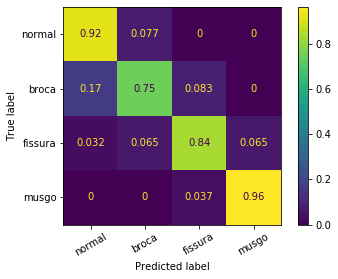

Rodada 1	-	Seed 4969
              precision    recall  f1-score   support

      normal       0.82      0.80      0.81        35
       broca       0.68      0.59      0.63        29
     fissura       0.74      0.91      0.82        22
       musgo       0.91      0.91      0.91        22

    accuracy                           0.79       108
   macro avg       0.79      0.80      0.79       108
weighted avg       0.79      0.79      0.78       108



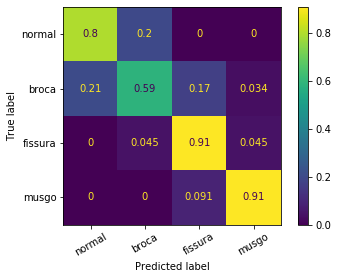

Rodada 2	-	Seed 3156
              precision    recall  f1-score   support

      normal       0.86      0.83      0.84        29
       broca       0.76      0.79      0.78        24
     fissura       0.86      0.89      0.88        28
       musgo       0.92      0.89      0.91        27

    accuracy                           0.85       108
   macro avg       0.85      0.85      0.85       108
weighted avg       0.85      0.85      0.85       108



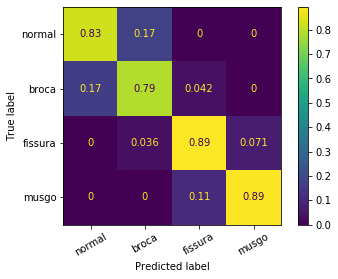

Rodada 3	-	Seed 5454
              precision    recall  f1-score   support

      normal       0.86      0.82      0.84        22
       broca       0.62      0.87      0.73        23
     fissura       0.86      0.68      0.76        37
       musgo       0.85      0.85      0.85        26

    accuracy                           0.79       108
   macro avg       0.80      0.80      0.79       108
weighted avg       0.81      0.79      0.79       108



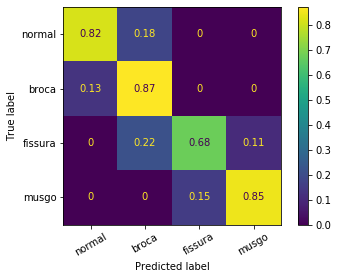

Rodada 4	-	Seed 7391
              precision    recall  f1-score   support

      normal       0.80      0.87      0.83        23
       broca       0.78      0.84      0.81        25
     fissura       0.82      0.72      0.77        32
       musgo       0.93      0.93      0.93        28

    accuracy                           0.83       108
   macro avg       0.83      0.84      0.83       108
weighted avg       0.83      0.83      0.83       108



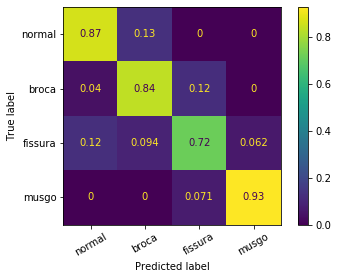

Rodada 5	-	Seed 7856
              precision    recall  f1-score   support

      normal       0.87      0.79      0.83        34
       broca       0.61      0.74      0.67        23
     fissura       0.64      0.75      0.69        24
       musgo       0.95      0.74      0.83        27

    accuracy                           0.76       108
   macro avg       0.77      0.76      0.76       108
weighted avg       0.78      0.76      0.77       108



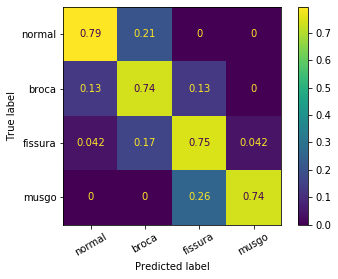

Rodada 6	-	Seed 555
              precision    recall  f1-score   support

      normal       0.92      0.81      0.86        27
       broca       0.62      0.86      0.72        21
     fissura       0.88      0.74      0.81        31
       musgo       0.93      0.93      0.93        29

    accuracy                           0.83       108
   macro avg       0.84      0.84      0.83       108
weighted avg       0.85      0.83      0.84       108



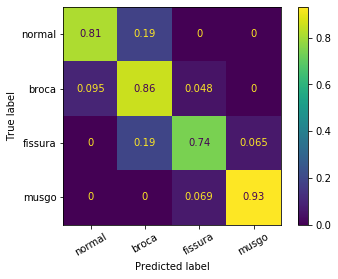

Rodada 7	-	Seed 7481
              precision    recall  f1-score   support

      normal       0.87      0.81      0.84        32
       broca       0.74      0.71      0.73        28
     fissura       0.66      0.73      0.69        26
       musgo       0.73      0.73      0.73        22

    accuracy                           0.75       108
   macro avg       0.75      0.75      0.75       108
weighted avg       0.75      0.75      0.75       108



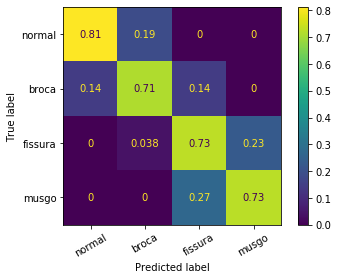

Rodada 8	-	Seed 3724
              precision    recall  f1-score   support

      normal       0.96      0.83      0.89        30
       broca       0.75      0.82      0.78        22
     fissura       0.81      0.93      0.87        28
       musgo       0.96      0.89      0.93        28

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.88      0.87      0.87       108



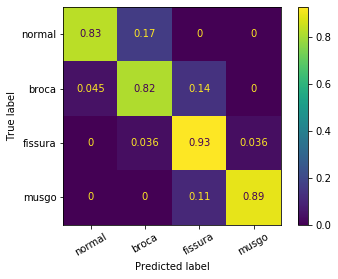

Rodada 9	-	Seed 4667
              precision    recall  f1-score   support

      normal       0.93      0.81      0.87        32
       broca       0.62      0.82      0.71        22
     fissura       0.75      0.75      0.75        28
       musgo       0.91      0.81      0.86        26

    accuracy                           0.80       108
   macro avg       0.80      0.80      0.79       108
weighted avg       0.82      0.80      0.80       108



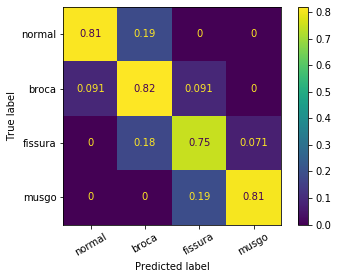

Rodada 10	-	Seed 2919
              precision    recall  f1-score   support

      normal       0.89      0.80      0.84        30
       broca       0.63      0.76      0.69        25
     fissura       0.81      0.68      0.74        31
       musgo       0.84      0.95      0.89        22

    accuracy                           0.79       108
   macro avg       0.79      0.80      0.79       108
weighted avg       0.80      0.79      0.79       108



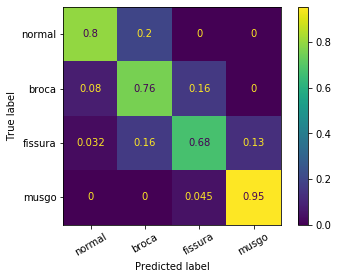

Rodada 11	-	Seed 5208
              precision    recall  f1-score   support

      normal       0.85      0.68      0.76        25
       broca       0.63      0.79      0.70        24
     fissura       0.81      0.91      0.86        33
       musgo       1.00      0.81      0.89        26

    accuracy                           0.81       108
   macro avg       0.82      0.80      0.80       108
weighted avg       0.83      0.81      0.81       108



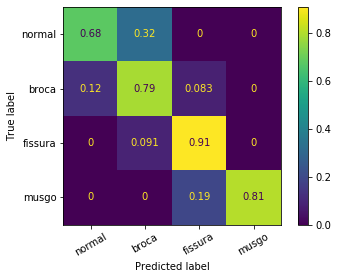

Rodada 12	-	Seed 3864
              precision    recall  f1-score   support

      normal       0.78      0.75      0.76        28
       broca       0.64      0.67      0.65        24
     fissura       0.81      0.85      0.83        26
       musgo       0.90      0.87      0.88        30

    accuracy                           0.79       108
   macro avg       0.78      0.78      0.78       108
weighted avg       0.79      0.79      0.79       108



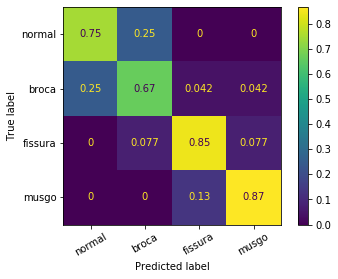

Rodada 13	-	Seed 4184
              precision    recall  f1-score   support

      normal       0.92      0.83      0.87        29
       broca       0.80      0.96      0.87        25
     fissura       0.92      0.82      0.87        28
       musgo       0.89      0.92      0.91        26

    accuracy                           0.88       108
   macro avg       0.88      0.88      0.88       108
weighted avg       0.89      0.88      0.88       108



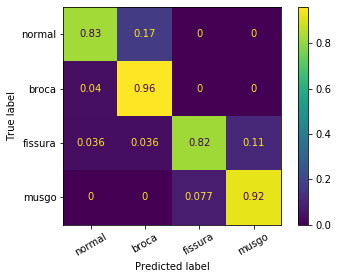

Rodada 14	-	Seed 6545
              precision    recall  f1-score   support

      normal       0.93      0.82      0.87        33
       broca       0.71      0.83      0.77        24
     fissura       0.80      0.87      0.83        23
       musgo       0.96      0.89      0.93        28

    accuracy                           0.85       108
   macro avg       0.85      0.85      0.85       108
weighted avg       0.86      0.85      0.85       108



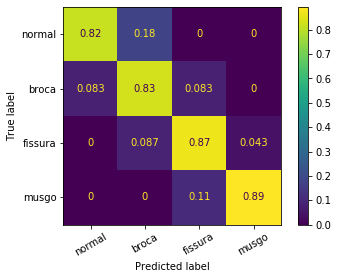

Rodada 15	-	Seed 4772
              precision    recall  f1-score   support

      normal       0.92      0.92      0.92        24
       broca       0.70      0.84      0.76        25
     fissura       0.77      0.75      0.76        32
       musgo       0.96      0.81      0.88        27

    accuracy                           0.82       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.83      0.82      0.83       108



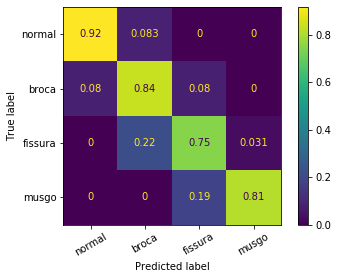

Rodada 16	-	Seed 7013
              precision    recall  f1-score   support

      normal       1.00      0.85      0.92        27
       broca       0.68      0.92      0.78        25
     fissura       0.85      0.74      0.79        31
       musgo       0.96      0.92      0.94        25

    accuracy                           0.85       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.87      0.85      0.86       108



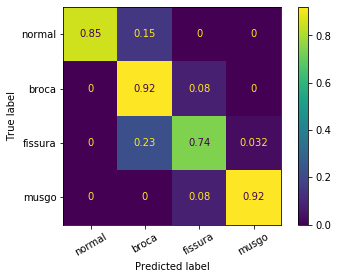

Rodada 17	-	Seed 6661
              precision    recall  f1-score   support

      normal       0.85      0.88      0.87        26
       broca       0.78      0.81      0.79        26
     fissura       0.86      0.83      0.85        30
       musgo       0.92      0.88      0.90        26

    accuracy                           0.85       108
   macro avg       0.85      0.85      0.85       108
weighted avg       0.85      0.85      0.85       108



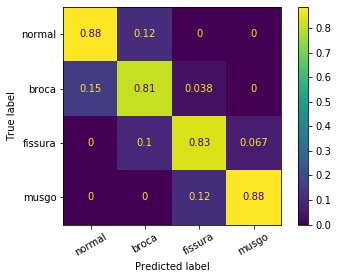

Rodada 18	-	Seed 6889
              precision    recall  f1-score   support

      normal       0.75      0.86      0.80        21
       broca       0.78      0.75      0.76        28
     fissura       0.79      0.68      0.73        28
       musgo       0.82      0.87      0.84        31

    accuracy                           0.79       108
   macro avg       0.78      0.79      0.78       108
weighted avg       0.79      0.79      0.79       108



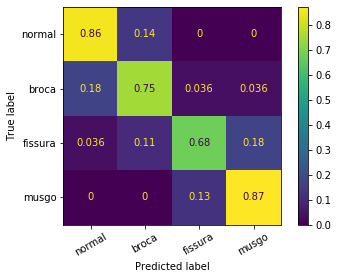

Rodada 19	-	Seed 5822
              precision    recall  f1-score   support

      normal       0.71      1.00      0.83        20
       broca       1.00      0.62      0.77        32
     fissura       0.73      0.90      0.81        30
       musgo       0.91      0.81      0.86        26

    accuracy                           0.81       108
   macro avg       0.84      0.83      0.82       108
weighted avg       0.85      0.81      0.81       108



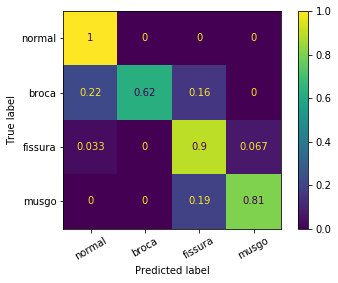

Rodada 20	-	Seed 4830
              precision    recall  f1-score   support

      normal       0.74      0.63      0.68        27
       broca       0.55      0.67      0.60        27
     fissura       0.73      0.73      0.73        26
       musgo       0.96      0.89      0.93        28

    accuracy                           0.73       108
   macro avg       0.74      0.73      0.73       108
weighted avg       0.75      0.73      0.74       108



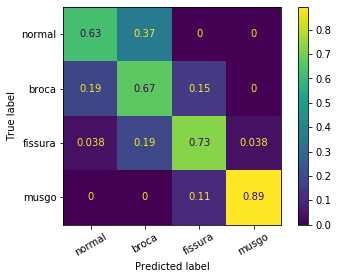

Rodada 21	-	Seed 1852
              precision    recall  f1-score   support

      normal       1.00      0.69      0.82        26
       broca       0.68      0.88      0.77        26
     fissura       0.80      0.82      0.81        34
       musgo       0.86      0.82      0.84        22

    accuracy                           0.81       108
   macro avg       0.83      0.80      0.81       108
weighted avg       0.83      0.81      0.81       108



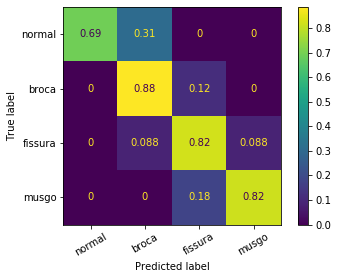

Rodada 22	-	Seed 434
              precision    recall  f1-score   support

      normal       0.72      0.90      0.80        20
       broca       0.77      0.71      0.74        28
     fissura       0.94      0.86      0.90        35
       musgo       0.96      0.96      0.96        25

    accuracy                           0.85       108
   macro avg       0.85      0.86      0.85       108
weighted avg       0.86      0.85      0.85       108



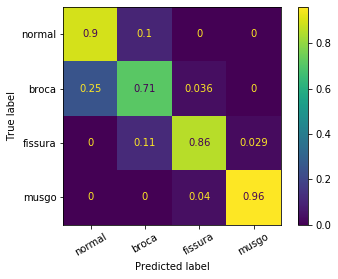

Rodada 23	-	Seed 2636
              precision    recall  f1-score   support

      normal       0.83      0.96      0.89        26
       broca       0.88      0.64      0.74        33
     fissura       0.71      0.85      0.77        26
       musgo       0.87      0.87      0.87        23

    accuracy                           0.81       108
   macro avg       0.82      0.83      0.82       108
weighted avg       0.82      0.81      0.81       108



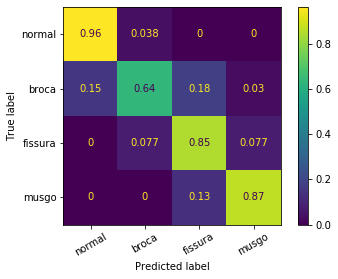

Rodada 24	-	Seed 2644
              precision    recall  f1-score   support

      normal       0.72      0.72      0.72        25
       broca       0.74      0.70      0.72        33
     fissura       0.83      0.96      0.89        26
       musgo       1.00      0.92      0.96        24

    accuracy                           0.81       108
   macro avg       0.82      0.82      0.82       108
weighted avg       0.82      0.81      0.81       108



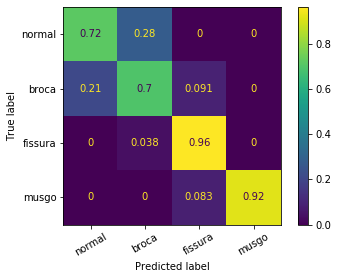

Rodada 25	-	Seed 4398
              precision    recall  f1-score   support

      normal       0.92      0.85      0.88        27
       broca       0.77      0.82      0.79        28
     fissura       0.64      0.76      0.70        21
       musgo       0.93      0.81      0.87        32

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.83      0.81      0.82       108



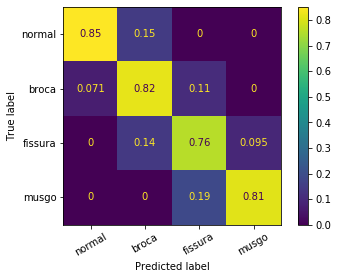

Rodada 26	-	Seed 1819
              precision    recall  f1-score   support

      normal       0.89      0.73      0.80        33
       broca       0.66      0.88      0.75        24
     fissura       0.91      0.77      0.83        26
       musgo       0.89      0.96      0.92        25

    accuracy                           0.82       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.82      0.83       108



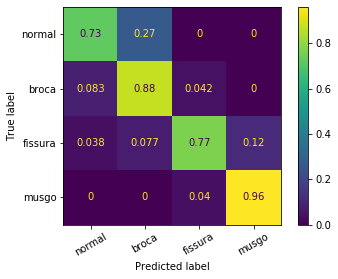

Rodada 27	-	Seed 3967
              precision    recall  f1-score   support

      normal       0.72      0.82      0.77        22
       broca       0.72      0.74      0.73        31
     fissura       0.87      0.69      0.77        29
       musgo       0.89      0.96      0.93        26

    accuracy                           0.80       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.80      0.80      0.80       108



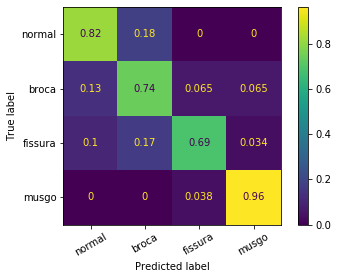

Rodada 28	-	Seed 5833
              precision    recall  f1-score   support

      normal       0.96      0.87      0.92        31
       broca       0.77      0.96      0.86        25
     fissura       0.96      0.81      0.88        27
       musgo       0.92      0.96      0.94        25

    accuracy                           0.90       108
   macro avg       0.90      0.90      0.90       108
weighted avg       0.91      0.90      0.90       108



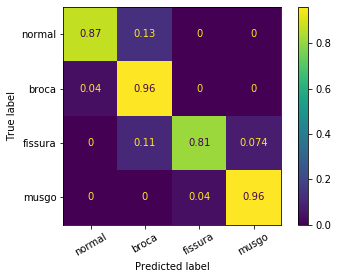

Rodada 29	-	Seed 171
              precision    recall  f1-score   support

      normal       0.75      0.75      0.75        20
       broca       0.70      0.73      0.72        26
     fissura       0.69      0.81      0.75        27
       musgo       0.97      0.80      0.88        35

    accuracy                           0.78       108
   macro avg       0.78      0.77      0.77       108
weighted avg       0.79      0.78      0.78       108



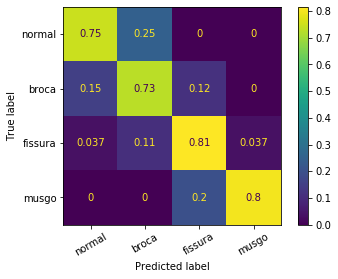

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_norm1_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

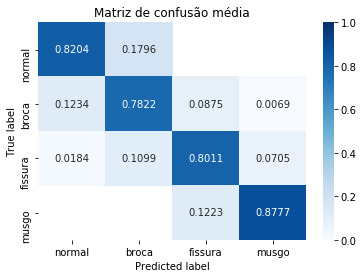

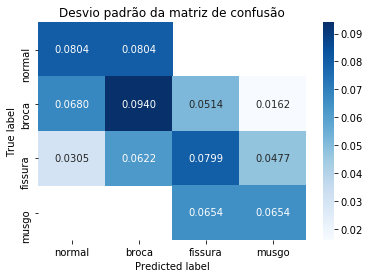

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.816975   0.831950   0.743126    0.799421   0.893750
std     0.039485   0.059162   0.059516    0.062224   0.048241
min     0.731481   0.680000   0.600000    0.690909   0.727273
25%     0.787037   0.800000   0.717423    0.751894   0.867391
50%     0.814815   0.837959   0.745370    0.806494   0.903811
75%     0.851852   0.872287   0.778623    0.854722   0.925926
max     0.898148   0.920000   0.872727    0.895522   0.960000


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.870370,0.872727,0.782609,0.866667,0.945455
0.787037,0.811594,0.629630,0.816327,0.909091
0.851852,0.842105,0.775510,0.877193,0.905660
0.787037,0.837209,0.727273,0.757576,0.846154
0.833333,0.833333,0.807692,0.766667,0.928571
0.759259,0.830769,0.666667,0.692308,0.833333
0.833333,0.862745,0.720000,0.807018,0.931034
0.750000,0.838710,0.727273,0.690909,0.727273
0.870370,0.892857,0.782609,0.866667,0.925926
0.796296,0.866667,0.705882,0.750000,0.857143


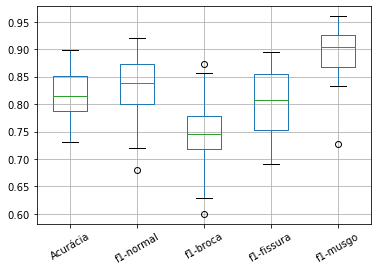

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')